In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

#1. Load the dataset
df_demand = pd.read_csv('train.csv')

print("\n")
#2. cek tipe data
print(df_demand.info())

print("\n")

#3. ubah kolom date menjadi datetime
df_demand['date'] = pd.to_datetime(df_demand['date'])

#4. lihat 5 data teratas
print(df_demand.head(5))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None


        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10


In [ ]:
print("date mulai dari tanggal :", df_demand['date'].min())
print("date sampai tanggal :", df_demand['date'].max())

In [9]:
#membuat fitur baru dari kolom date
df_demand['year'] = df_demand['date'].dt.year
df_demand['month'] = df_demand['date'].dt.month
df_demand['day'] = df_demand['date'].dt.day
df_demand['dayofweek'] = df_demand['date'].dt.dayofweek
df_demand['isweekend'] = df_demand['dayofweek'].apply(lambda x: 1 if x >=5 else 0)

#lihat 5 data teratas setelah menambahkan fitur baru
print(df_demand.head(5))

        date  store  item  sales  year  month  day  dayofweek  isweekend
0 2013-01-01      1     1     13  2013      1    1          1          0
1 2013-01-02      1     1     11  2013      1    2          2          0
2 2013-01-03      1     1     14  2013      1    3          3          0
3 2013-01-04      1     1     13  2013      1    4          4          0
4 2013-01-05      1     1     10  2013      1    5          5          1


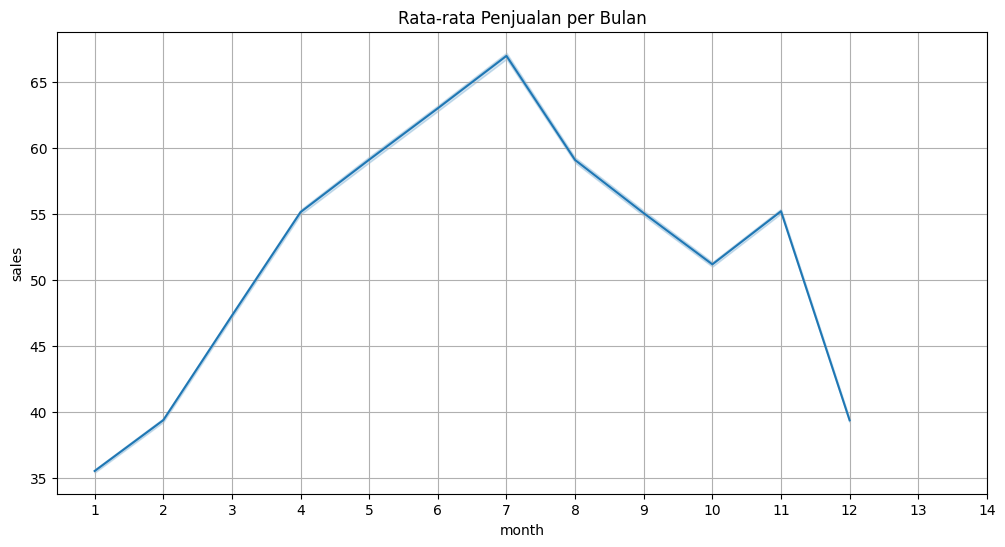

In [10]:
plt.figure(figsize=(12,6))
#kita kumpulkanrata-rata penjualan per bulan 
sns.lineplot(x='month', y='sales', data=df_demand)
plt.title('Rata-rata Penjualan per Bulan')
plt.xticks(range(1,15))
plt.grid(True)
plt.show()

In [11]:
#membuat fitur penjualan 1 hari yang lalu, 7 hari yang lalu, dan 30 hari yang lalu
df_demand['sales_lag_1'] = df_demand.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1))
df_demand['sales_lag_7'] = df_demand.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(7))
df_demand['sales_lag_30'] = df_demand.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(30))

# Karena kita menggeser data, baris awal pasti akan ada yang kosong (NaN). Kita hapus saja.
df_demand.dropna(inplace=True)

df_demand[['date', 'sales', 'sales_lag_1', 'sales_lag_7']].head(10)

,date,sales,sales_lag_1,sales_lag_7
30,2013-01-31,13,9.0,8.0
31,2013-02-01,11,13.0,14.0
32,2013-02-02,21,11.0,12.0
33,2013-02-03,15,21.0,12.0
34,2013-02-04,14,15.0,11.0
35,2013-02-05,9,14.0,6.0
36,2013-02-06,10,9.0,9.0
37,2013-02-07,13,10.0,13.0
38,2013-02-08,11,13.0,11.0
39,2013-02-09,14,11.0,21.0


In [12]:
#membagi data berdasarkan tahun 
train = df_demand[df_demand['year'] < 2017]
test = df_demand[df_demand['year'] == 2017]

#tentukan x feature dan y target 
features = ['store', 'item','month', 'dayofweek', 'isweekend', 'sales_lag_1', 'sales_lag_7', 'sales_lag_30']
X_train = train[features]
y_train = train['sales']
X_test = test[features]
y_test = test['sales']

print(f"data belajar : {X_train.shape}")
print(f"data ujian {X_test.shape}")

data belajar : (715500, 8)
data ujian (182500, 8)


In [13]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

#1. inisisialisasi model
model_demand = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)

#2.training model(model mulai belajar)
model_demand.fit(X_train, y_train)

#3. prediksi ke masa depan 
y_pred = model_demand.predict(X_test)

print('model berhasil dilatih ')

model berhasil dilatih 


In [14]:
mae = mean_absolute_error(y_test, y_pred)
print(f"rata-rata kesalahan absolut(MAE) : {mae:.2f} items")

#membandingkan dengan rata-rata asli 
print(f"rata=rata penjualan asli : {y_test.mean():.2f} items")

rata-rata kesalahan absolut(MAE) : 6.78 items
rata=rata penjualan asli : 58.82 items


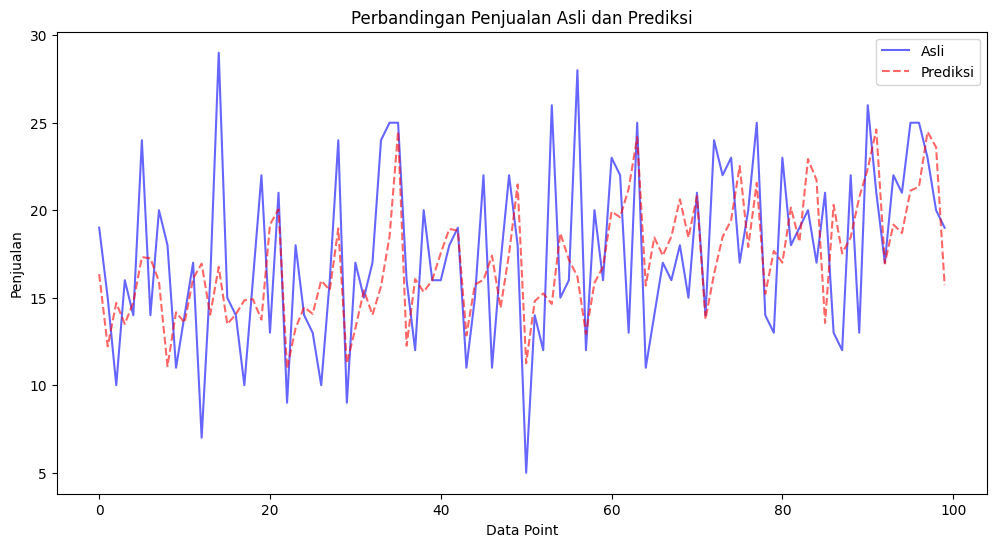

In [18]:
#membuat dataframe untuk perbandingan hasil prediksi dan data asli
comparison = pd.DataFrame({'asli':y_test, 'prediksi':y_pred})

#ambil sampel 100 data pertama
plt.figure(figsize=(12,6))
plt.plot(comparison['asli'].values[:100], label='Asli', color='blue', alpha=0.6)
plt.plot(comparison['prediksi'].values[:100], label='Prediksi', color='red', linestyle='--', alpha=0.6)
plt.legend()
plt.title('Perbandingan Penjualan Asli dan Prediksi')
plt.xlabel('Data Point')
plt.ylabel('Penjualan')
plt.show()

C:\Users\haida\AppData\Local\Temp\ipykernel_2408\2820221489.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


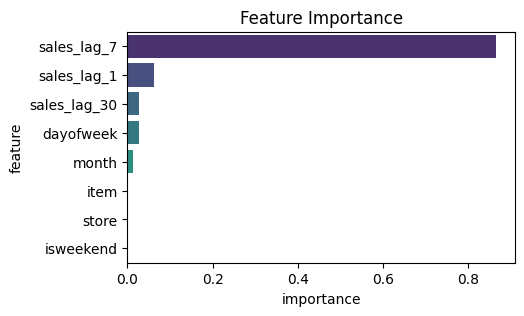

In [19]:
importance = model_demand.feature_importances_
feature_names = features    
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance}).sort_values(by='importance', ascending=False)
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(5,3))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV

# 1. Tentukan parameter yang ingin kita coba-coba
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 7]
}

# 2. Setup pencarian otomatis
grid_search = GridSearchCV(estimator=model_demand, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=3)

# 3. Mulai pencarian (Fitting)
grid_search.fit(X_train, y_train)

print("Setelan terbaik ditemukan:", grid_search.best_params_)

Setelan terbaik ditemukan: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}


In [22]:
import joblib

# Menyimpan model ke dalam file bernama 'model_forecasting_toko.pkl'
joblib.dump(grid_search.best_estimator_, 'model_forecasting_toko.pkl')

print("Model berhasil disimpan! Kamu sekarang punya file .pkl yang bisa dikirim ke tim IT.")

Model berhasil disimpan! Kamu sekarang punya file .pkl yang bisa dikirim ke tim IT.
